# Homework 4: Volatility models

In [1]:
import arch
from arch.__future__ import reindexing

import wrds
import pandas
import numpy
import math
import scipy.stats

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
from scipy.optimize import minimize

from matplotlib import pyplot as plt

In [2]:
conn = wrds.Connection(wrds_username='wmann')
FF3F = conn.get_table(library='ff_all',table='factors_monthly',coerce_float=True)
FF3F['month'] = pandas.to_datetime(FF3F['date']).dt.to_period('M')
FF3F = FF3F.drop('date',axis=1).set_index('month')
FF3F = FF3F['1963-07':'2001-07']

Loading library list...
Done


### The data you will use:

We will look at returns to three basic strategies in the stock market. 

We will measure all three as *log* returns, to be consistent with our examples from class, though this makes very little difference to the results. Remember that if the return in any date is $r$, then the log return is $\ln(1+r)$.

**UMD**: The return to a dollar-neutral strategy that goes long high-momentum stocks and short low-momentum stocks
<br>
*(and holds the proceeds from the short sale in cash earning zero interest)*

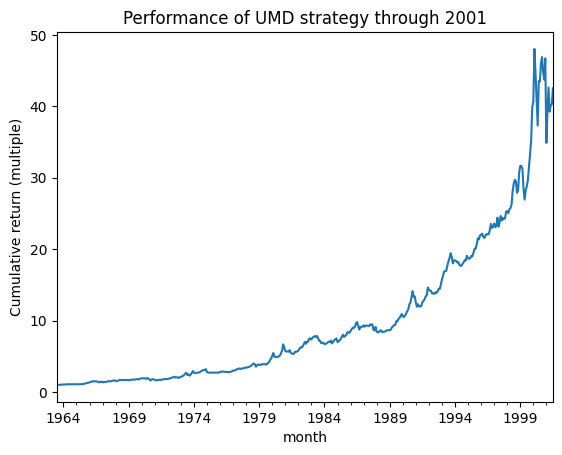

In [3]:
UMD = numpy.log(1+FF3F['umd'])
numpy.exp(UMD.cumsum()).plot(title="Performance of UMD strategy through 2001",ylabel="Cumulative return (multiple)");

**HML**: The return to a dollar-neutral strategy that goes long value stocks and short growth stocks 
<br>
*(and holds the proceeds from the short sale in cash earning zero interest)*

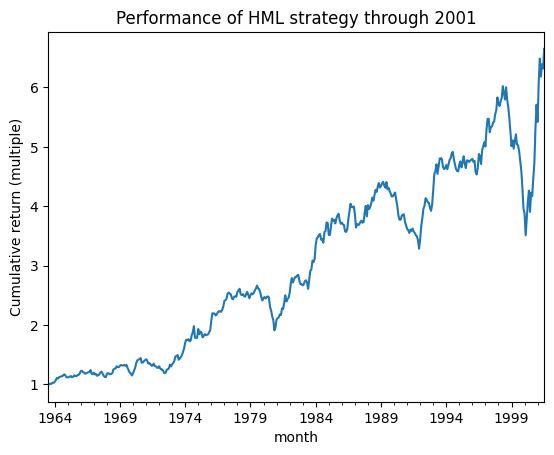

In [4]:
HML = numpy.log(1+FF3F['hml'])
numpy.exp(HML.cumsum()).plot(title="Performance of HML strategy through 2001",ylabel="Cumulative return (multiple)");

**"Combo"**: The return to a strategy that maintains 50% dollar weighting on UMD, and 50% on HML. Some practitioners (notably AQR) advocate this form of diversification across strategies as a way to get a better risk/return tradeoff.

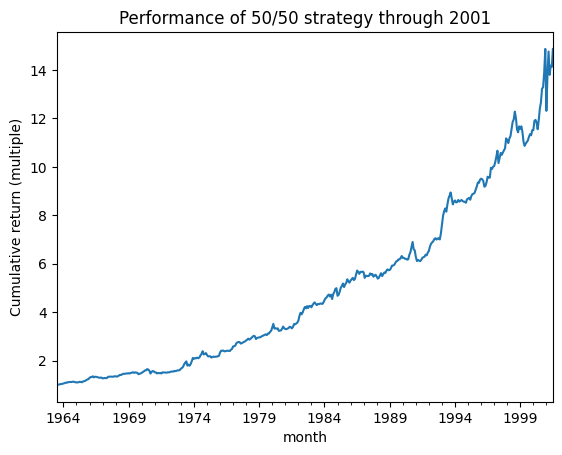

In [5]:
Combo = numpy.log(1 + 0.5*UMD + 0.5*HML)
numpy.exp(Combo.cumsum()).plot(title="Performance of 50/50 strategy through 2001",ylabel="Cumulative return (multiple)");

### Your task:

You will consider the value-at-risk of several strategies in the stock market, at a time of high recent market volatility, July 2001.

For each of the three strategies mentioned above (UMD, HML, and "Combo"), perform the following steps:
- (a) Calculate the 12-month 5% value-at-risk ignoring any time-series effects in volatility (that is, assuming that volatility is a constant number).
- (b) Use Engle’s ARCH-LM test to show that the analysis in (a) is actually invalid.
- (c) Estimate a GARCH(1,1) model of the volatility of the strategy’s returns.
- (d) Show that when we apply Engle’s ARCH-LM test to the residuals from the model in part (c), we fail to reject the null hypothesis, and explain what this means.
- (e) Plot the GARCH estimates of conditional volatility over time.
- (f) Calculate the 12-month 5% value-at-risk based on the GARCH estimates. 

Final questions: 
- Why is your answer to (f) always greater than your answer to (a)?
- Why is your answer to (f) lower for the "Combo" strategy, than for either of the two strategies UMD or HML on its own?

# 1. Analysis of momentum strategy (UMD)

### 1(a) 12-month value at risk with constant volatility

In [6]:
mean = 12*UMD.mean()
vol = math.sqrt(12)*UMD.std()

percentile = mean - 1.645*vol
VAR = -percentile
VAR

0.1253972010606212

### 1(b) Test for predictability in volatility

Implement the Engle ARCH-LM test. The second number is the p-value under the null of no predictability in volatility.

In [7]:
het_arch(UMD,nlags=1)

(18.49053365558298,
 1.7075029167290692e-05,
 19.18747575858432,
 1.472775359857994e-05)

In [8]:
het_arch(UMD)

(63.25236584643139,
 8.740194058905517e-10,
 7.18650202752986,
 1.5878633394513538e-10)

### 1(c) Estimate GARCH model

In [9]:
GARCH_results_UMD = arch.arch_model(100*UMD,vol='garch',p=1,q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1801.2942530307537
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24146.450816581593
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1544.8916752879186
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1203.6790354291004
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1714.2145016053576
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1203.6487663772857
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1203.6474483867282
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1203.6473781426525
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1203.6473780363922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1203.6473781426525
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9


### 1(d) Check that there is no predictability in the standardized *squared* residuals.

(0.0013052662704815532,
 0.9711799221816186,
 0.0012995451382461789,
 0.9712589696027083)

(7.096373370920988, 0.7163164754683998, 0.7033401414374773, 0.7215635220701768)

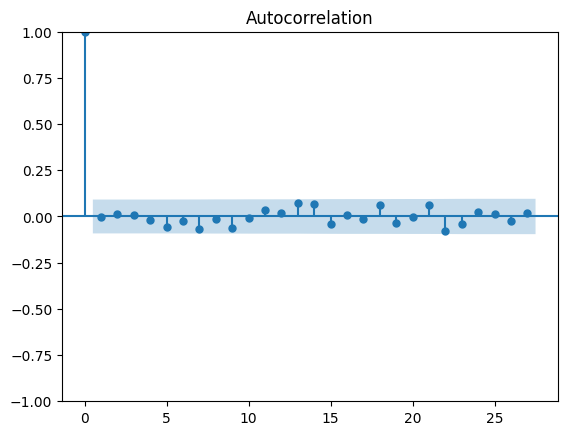

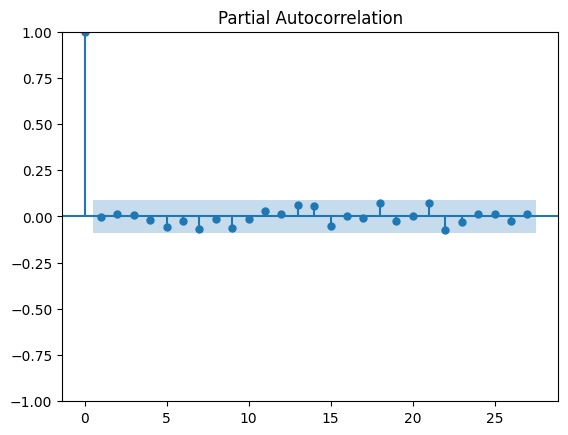

In [10]:
GARCH_UMD_resid_standardized = GARCH_results_UMD.resid / GARCH_results_UMD.conditional_volatility
plot_acf( GARCH_UMD_resid_standardized.pow(2) )
plot_pacf( GARCH_UMD_resid_standardized.pow(2) , method='ywm' )
display( het_arch( GARCH_UMD_resid_standardized , nlags=1 ) )
display( het_arch( GARCH_UMD_resid_standardized ) )

### 1(e) Plot estimates of time-varying volatility

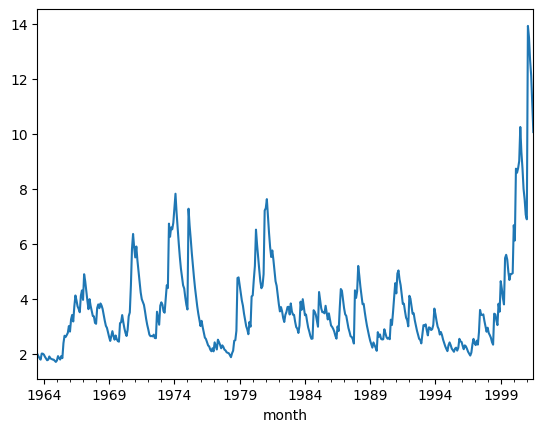

In [11]:
GARCH_results_UMD.conditional_volatility.plot();

### 1(f) 12-month value-at-risk calculation based on GARCH volatility model

In [12]:
forecast = GARCH_results_UMD.forecast(horizon=12)

mean = forecast.mean.iloc[-1].sum() / 100
vol = math.sqrt( forecast.variance.iloc[-1].sum() ) / 100

percentile = mean - 1.645*vol
VAR = -percentile
VAR

0.46436300701172506

# 2. Analysis of value strategy (HML)

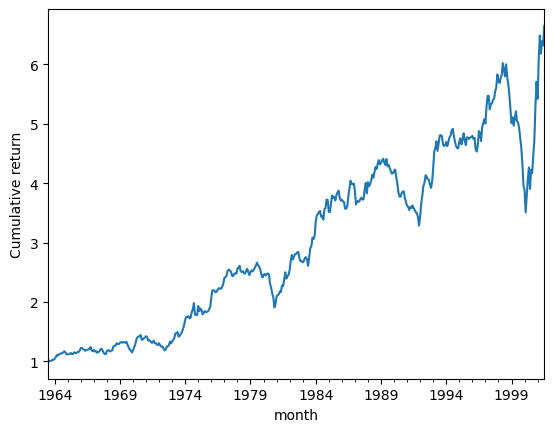

In [13]:
numpy.exp(HML.cumsum()).plot();
plt.ylabel("Cumulative return");

### 2(a) 12-month value at risk with constant volatility

In [14]:
mean = 12*HML.mean()
vol = math.sqrt(12)*HML.std()

percentile = mean - 1.645*vol
VAR = -percentile
VAR

0.1154747619315963

### 2(b) Test for predictability in volatility

In [15]:
het_arch(HML,nlags=1)

(49.40958636298921,
 2.0772807283035964e-12,
 55.170883169969514,
 5.519337725356899e-13)

### 2(c) Estimate GARCH model

In [16]:
GARCH_results_HML = arch.arch_model(100*HML,vol='garch',p=1,q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2073.5513177835564
Iteration:      2,   Func. Count:     13,   Neg. LLF: 514087838.79971707
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1290.9853471817485
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1100.4212140871143
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1098.3073770949604
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1091.4055752928284
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1089.6328334455059
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1089.5183540644553
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1089.516179650494
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1089.5161748343955
Iteration:     11,   Func. Count:     66,   Neg. LLF: 1089.5161715249787
Iteration:     12,   Func. Count:     70,   Neg. LLF: 1089.5161715251277
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1089.5161715249787
            Iter

### 2(d) Check that there is no predictability in the standardized squared residuals.

(7.717817590171551, 0.6563782169394798, 0.7660152412408677, 0.6617120153946627)

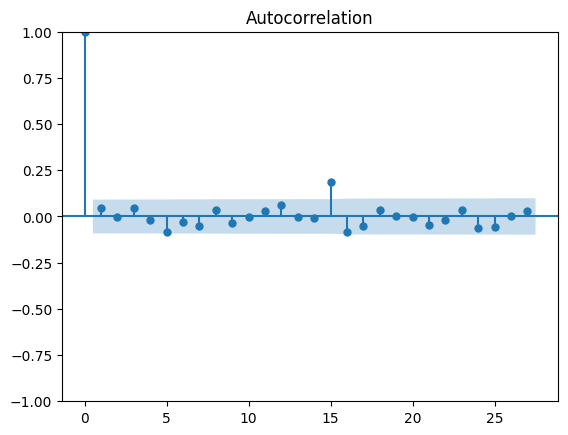

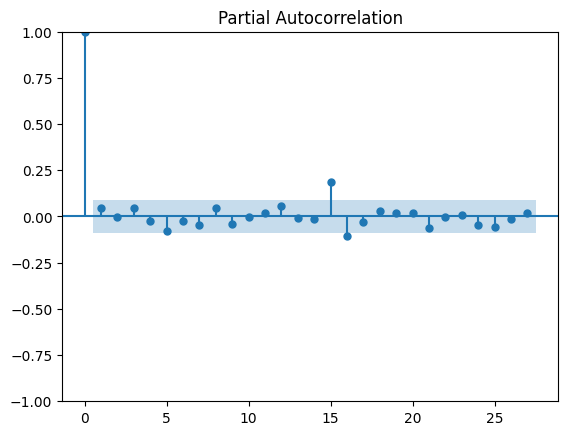

In [17]:
GARCH_HML_resid_standardized = GARCH_results_HML.resid / GARCH_results_HML.conditional_volatility
plot_acf( GARCH_HML_resid_standardized.pow(2) )
plot_pacf( GARCH_HML_resid_standardized.pow(2) , method='ywm' )
het_arch(GARCH_HML_resid_standardized)

### 2(e) Plot estimates of time-varying volatility

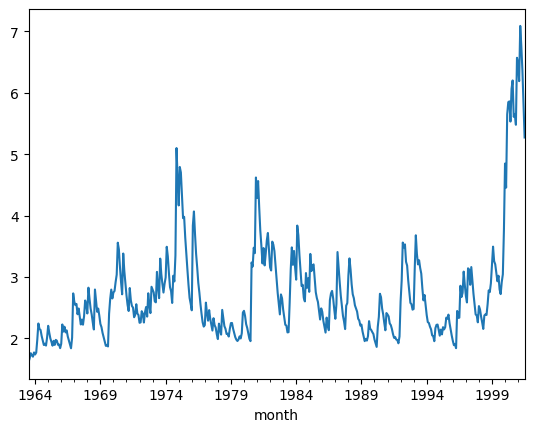

In [18]:
GARCH_results_HML.conditional_volatility.plot();

### 2(f) 12-month value-at-risk calculation based on GARCH volatility model

In [19]:
forecast = GARCH_results_HML.forecast(horizon=12)
mean = forecast.mean.iloc[-1].sum() / 100
vol = math.sqrt( forecast.variance.iloc[-1].sum() ) / 100

percentile = mean - 1.645*vol
VAR = -percentile
VAR

0.23221145442279073

# 3. Analysis of combination strategy (50% UMD, 50% HML)

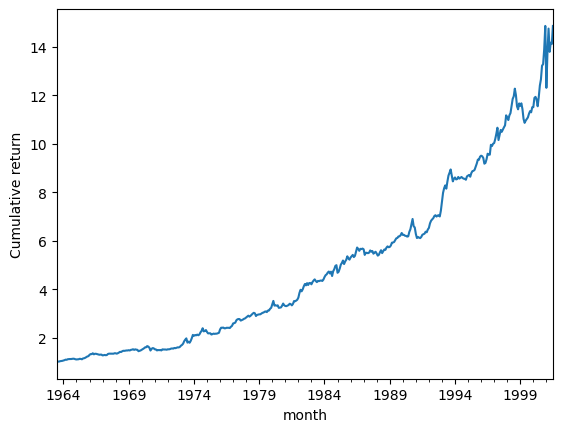

In [20]:
numpy.exp(Combo.cumsum()).plot();
plt.ylabel("Cumulative return");

### 3(a) 12-month value at risk with constant volatility

In [21]:
mean = 12*Combo.mean()
vol = math.sqrt(12)*Combo.std()

percentile = mean - 1.645*vol
VAR = -percentile
VAR

0.05759705158110934

### 3(b) Test for predictability in volatility

In [22]:
het_arch(Combo,nlags=1)

(77.19955104852927,
 1.5452866546047757e-18,
 92.5252234337306,
 4.660736718056118e-20)

### 3(c) Estimate GARCH model

In [23]:
GARCH_results_Combo = arch.arch_model(100*Combo,vol='garch',p=1,o=0,q=1).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2335.093495123873
Iteration:      2,   Func. Count:     14,   Neg. LLF: 85857.2813488075
Iteration:      3,   Func. Count:     20,   Neg. LLF: 952.5443708854006
Iteration:      4,   Func. Count:     27,   Neg. LLF: 953.4307604026501
Iteration:      5,   Func. Count:     33,   Neg. LLF: 938.0579602465248
Iteration:      6,   Func. Count:     39,   Neg. LLF: 937.4646229273715
Iteration:      7,   Func. Count:     44,   Neg. LLF: 937.3904330552025
Iteration:      8,   Func. Count:     49,   Neg. LLF: 937.3872134487544
Iteration:      9,   Func. Count:     54,   Neg. LLF: 937.3869984587818
Iteration:     10,   Func. Count:     58,   Neg. LLF: 937.3869984591597
Optimization terminated successfully    (Exit mode 0)
            Current function value: 937.3869984587818
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10


### 3(d) Check that there is no predictability in the standardized squared residuals.

(3.9860519735877022,
 0.9479740086058043,
 0.39229434382969214,
 0.9499640109210459)

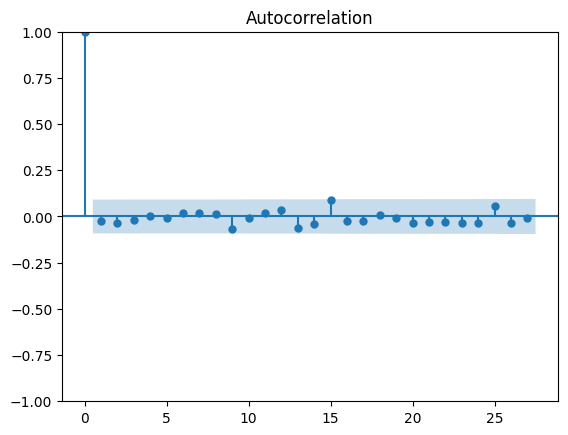

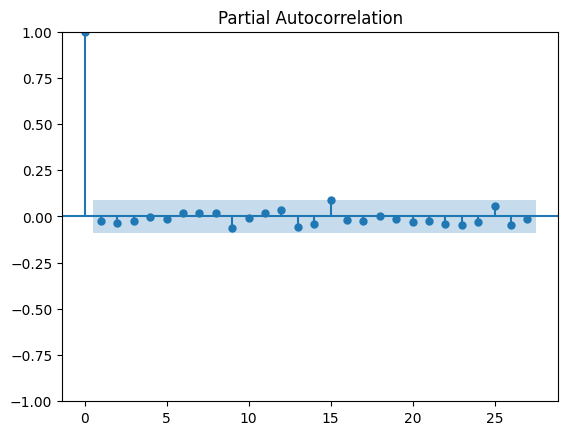

In [24]:
GARCH_Combo_resid_standardized = GARCH_results_Combo.resid / GARCH_results_Combo.conditional_volatility
plot_acf(GARCH_Combo_resid_standardized.pow(2) )
plot_pacf(GARCH_Combo_resid_standardized.pow(2) , method='ywm')
het_arch(GARCH_Combo_resid_standardized)

### 3(e) Plot estimates of time-varying volatility

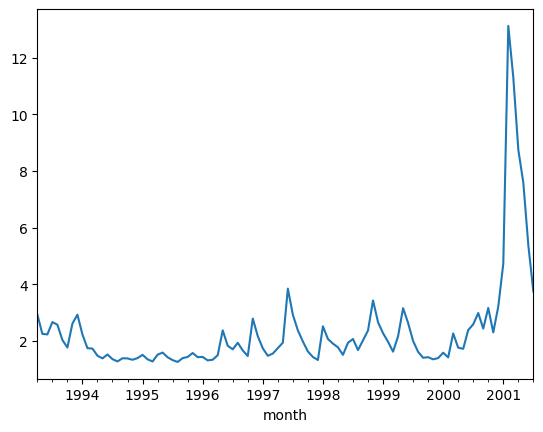

In [25]:
GARCH_results_Combo.conditional_volatility.iloc[-100:].plot();

### 3(f) 12-month value-at-risk calculation based on GARCH volatility model

In [26]:
forecast = GARCH_results_Combo.forecast(horizon=12)

mean =  forecast.mean.iloc[-1].sum() / 100
vol = math.sqrt( forecast.variance.iloc[-1].sum() ) / 100

percentile = mean - 1.645*vol
VAR = -percentile
VAR

0.1444857721316683